In [1]:
import numpy as np
from PIL import Image
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps




2024-02-26 22:31:01.732332: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 22:31:01.777943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:31:01.777991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:31:01.779206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 22:31:01.786622: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 22:31:01.787413: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Data Preparation  
**ImageFolder**: Generic Dataset that you can use with your images provided, that they are organized into subfolders. Each subfolder is named after class. The root folder is `train` in below example.

train/paper/image1.png  
train/paper/image2.png

train/rock/image1.png  
train/rock/image2.png

train/scissors/image1.png  
train/scissors/image2.png

In [5]:
# download_rps('/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch')

In [6]:
 # Temporary Dataset
temp_transform=Compose(transforms=[Resize(28),ToTensor()])
temp_dataset=ImageFolder(root='rps',transform=temp_transform)

In [13]:
temp_dataset[2][0].shape,temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

## Standardization  
We need to know their mean and std!

In [17]:
# Temporary dataloader
temp_loader=DataLoader(dataset=temp_dataset,batch_size=16)


We need statistics(mean pixel and std) for each channel as required by the Normalize() function.

In [20]:
@staticmethod
def statistics_per_channel(images,labels):
    # NCHW
    n_samples,n_channels,n_height,n_weight=images.size()
    # Flatten HW into single dimention
    flatten_per_channel=images.reshape(n_samples,n_channels,-1)

    # compute statistics per each image per channel
    # Average pixel value per channel 
    means=flatten_per_channel.mean(axis=2) # n_samples, n_channels
    # Standard Deviation of pixel values per channel
    stds=flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini batch (1, n_channels)
    sum_means=means.sum(axis=0)
    sum_stds=stds.sum(axis=0)

    # Make a tensor of shape (1,n_channels) with the number of samples in a mini-batch
    n_samples=torch.tensor([n_samples]*n_channels).float()

    # stack the tensors on top of one another (3,n_channels)
    return torch.stack([n_samples,sum_means,sum_stds],axis=0)

setattr(StepByStep,'statistics_per_channel',statistics_per_channel)

In [21]:
first_images,first_labels=next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images,first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [26]:
# Get sum for the whole dataset
results=StepByStep.loader_apply(temp_loader,StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

Lets make a function that take dataloader and returns an instance of a Normalize function


In [27]:
@staticmethod
def make_normalizer(loader):
    total_samples,total_means,total_stds=StepByStep.loader_apply(loader,StepByStep.statistics_per_channel)
    norm_mean=total_means/total_samples
    norm_std=total_stds/total_samples
    return Normalize(mean=norm_mean,std=norm_std)

setattr(StepByStep,'make_normalizer',make_normalizer)

In [28]:
# Creating Normalizer Transform
normalizer=StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

## The Real Datasets

In [29]:
# Data preparation
composer=Compose(transforms=[Resize(28),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

# Builds a loader of each set
train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)



## Three Channel Convolutions


every filter has 3 channels since our image has 3 channels.

In [32]:
regions=np.array([5,0,8,1,9,5,6,0,2,0,5,4,8,1,9,4,8,1,4,2,0,6,3,0,5,2,8])
regions=regions.reshape(1,3,3,3)

In [33]:
regions.shape

(1, 3, 3, 3)

In [40]:
three_channel_filter=np.array([0,3,0,1,0,1,2,1,0,2,1,0,0,3,1,1,-1,0,1,0,3,-1,-2,0,2,0,1])
three_channel_filter=three_channel_filter.reshape(-1,3,3,3)
three_channel_filter.shape

(1, 3, 3, 3)

In [41]:
result=F.conv2d(input=torch.as_tensor(regions),weight=torch.as_tensor(three_channel_filter))
result,result.shape

(tensor([[[[41]]]]), torch.Size([1, 1, 1, 1]))

In [94]:
# Fancier Model
class CNN2(nn.Module):
    def __init__(self,n_filters,p=0.0):
        super(CNN2,self).__init__()
        self.n_filters=n_filters
        self.p=p
        # We will use n_filters as output channels for both convolutional blocks
        self.conv1=nn.Conv2d(in_channels=3,out_channels=n_filters,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=3,out_channels=n_filters,kernel_size=3)

        # Create Linear layers
        self.fc1=nn.Linear(in_features=n_filters*5*5,out_features=50) # Hidden Layer
        self.fc2=nn.Linear(in_features=50,out_features=3) # Output Layer

        # Create dropout layers
        self.drop=nn.Dropout(self.p)

        # Fancier Model- Featurizer
    def featurizer(self,x):
        # First convolutional block
        # 3@28x28 -> n_filters@26x26 -> n_filters@13x13
        x=self.conv1(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)

        # Second convolutional block
        # n_filters@13x13 -> n_filters@11x11 -> n_filters@5x5
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)

        # input dimention: n_filters@5x5
        # output dimention: n_filtersx5x5
        x=nn.Flatten()(x)
        return x

    # Fancier Model- Classifier
    def classifier(self,x):
        # Hidden Layer: n_filters@5x5 -> 50
        if self.p>0:
            x=self.drop(x)
        x=self.fc1(x)
        x=F.relu(x)

        # output layer: 50 -> 3
        if self.p>0:
            x=self.drop(x)
        x=self.fc2(x)
        return x

    def forward(self,x):
        x=self.featurizer(x)
        x=self.classifier(x)
        return x

In [46]:
# Fancier Model- Classifier
def classifier(self,x):
    # Hidden Layer: n_filters@5x5 -> 50
    if self.p>0:
        x=self.drop(x)
    x=self.fc1(x)
    x=F.relu(x)

    # output layer: 50 -> 3
    if self.p>0:
        x=self.drop(x)
    x=self.fc2(x)
    return x

In [47]:
def forward(self,x):
    x=self.featurizer(x)
    x=self.classifier(x)
    return x

## Dropout

Sometimes model may rely on features specifically found on training set. Model may try to find an easy way out to achieve the target

In [48]:
# Feature normalization
dropping_model=nn.Sequential(nn.Dropout(p=0.5))


In [50]:
spaced_points=torch.linspace(0.1,1.1,11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [51]:
torch.manual_seed(44)

dropping_model.train()
output_train=dropping_model(spaced_points) # remianing elements will be adjusted by 1/p
output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

In [55]:
output_train/spaced_points

tensor([0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 2.])

In [58]:
F.linear(output_train,weight=torch.ones(11),bias=torch.tensor(0)) # This would be 4.8000 withoput adjusting factor

tensor(9.4000)

Since There is no dropping in evaluation, It will produce slightly different results, 

In [61]:
dropping_model.eval()
output_eval=dropping_model(spaced_points) # There is no adjusting factor
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [62]:
F.linear(output_eval,weight=torch.ones(11),bias=torch.tensor(0))


tensor(6.6000)

Dropping is probabilistic

In [64]:
# torch.manual_seed(17)
# p=0.5
# distrib_outputs=torch.tensor([F.linear(F.dropout(spaced_points,p=p),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])


In [68]:
# distrib_outputs.reshape(-1,1).shape

torch.Size([1000, 1])

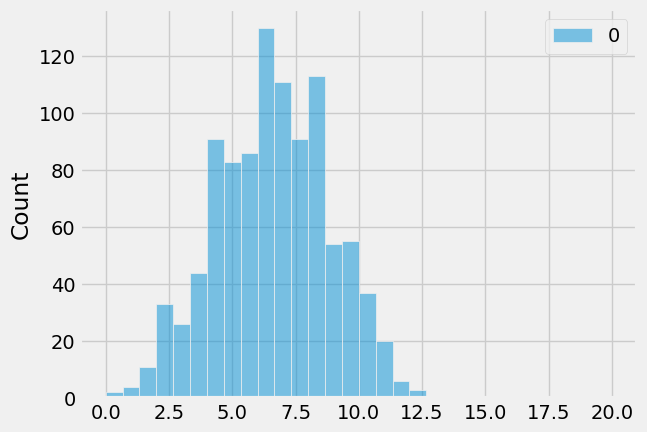

In [80]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(distrib_outputs.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

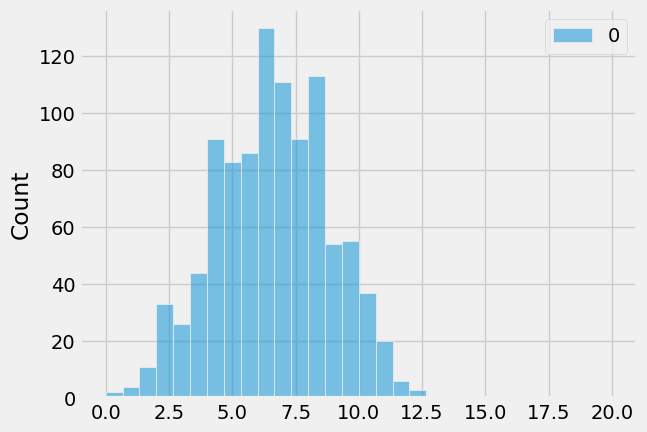

In [71]:
# torch.mean(distrib_outputs,axis=0) tensor(6.5694)

tensor(6.5694)

Output for simple linear layer with dropput will be between 0 and 13. Not exactly 6.6

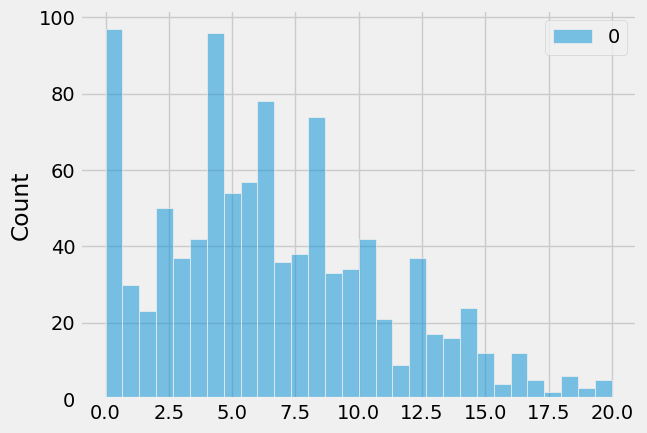

In [85]:
# # Lets try drop of p=0.8
# distrib_outputs2=torch.tensor([F.linear(F.dropout(spaced_points,p=0.8),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])

# sns.histplot(distrib_outputs2.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

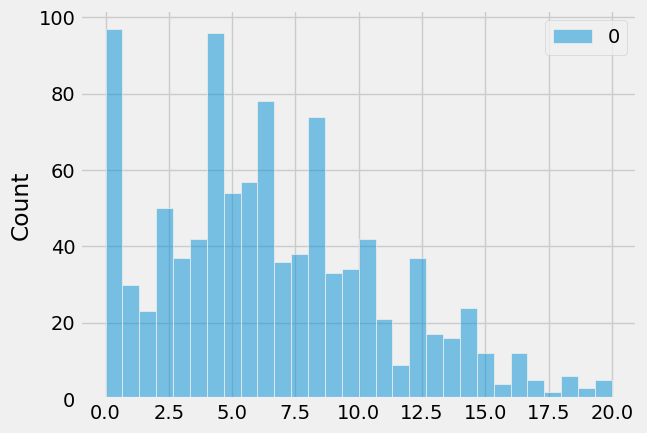

In [98]:
# # Lets try drop of p=0.2
# distrib_outputs3=torch.tensor([F.linear(F.dropout(spaced_points,p=0.2),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])

# sns.histplot(distrib_outputs3.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

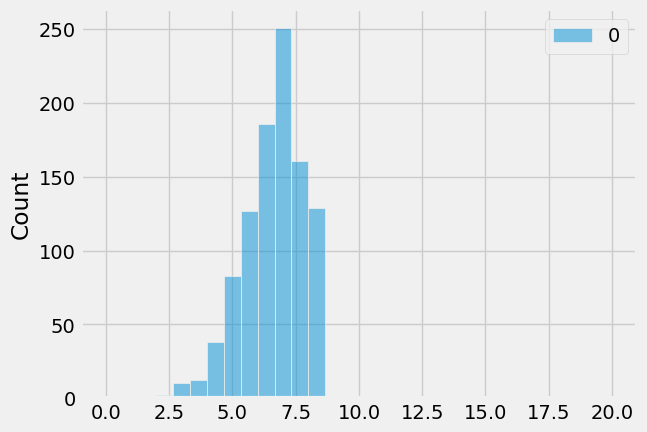

The variance of the distribution of outputs grows with dropout probability

## Tow Diemntional Dropout

Specific dropout with convolutional layers: instead of drooping individual inputs, it drops entire filters. Randomly dropping pixel values pixels doesnt do much since adjacent pixels are strongly correlated.

## Model Configuration

In [95]:
torch.manual_seed(13)
model_cnn2=CNN2(n_filters=5,p=0.3)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2=optim.Adam(model_cnn2.parameters(),lr=3e-4)

In [96]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

In [97]:
sbs_cnn2=StepByStep(model_cnn2,multi_loss_fn,optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader,val_loader)
sbs_cnn2.train(10)

RuntimeError: Given groups=1, weight of size [5, 3, 3, 3], expected input[16, 5, 13, 13] to have 3 channels, but got 5 channels instead